In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import time, os
from tqdm import tqdm

from scipy import optimize
from sklearn import datasets

In [2]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow
import nflib.coupling_flows as icf
import nflib.inn_flow as inn
import nflib.res_flow as irf

In [3]:
from torch import distributions
from torch.distributions import MultivariateNormal

In [4]:
# Lightweight datasets
class BlobDataset():
    
    def __init__(self, num_points=1000, nd=3):
        self.x, self.c = datasets.make_blobs(n_samples=num_points, n_features=nd, centers=nd+1)
        self.x = (self.x-self.x.mean())/self.x.std()
        self.x = self.x.astype(np.float32)
        
    def sample(self,n_sample=200):
        rand_indx = np.random.permutation(len(self.x))[:n_sample]
        return torch.from_numpy(self.x[rand_indx]), torch.from_numpy(self.c[rand_indx])


d = BlobDataset()

x, c = d.sample(128)
%matplotlib tk
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], marker=".", c=c)
plt.show()

In [5]:
prior = MultivariateNormal(torch.zeros(3), torch.eye(3))

# actf = inn.Swish
actf = irf.Swish

flows = [
    ActNorm(3),
#     iMLP_Flow(3, 100, activation=actf),
    irf.ResidualFlow(3, [100], activation=actf),
    ActNorm(3),
#     iMLP_Flow(3, 100, activation=actf),
    irf.ResidualFlow(3, [100], activation=actf),
        ]
model = NormalizingFlow(flows, prior)

In [6]:
model

NormalizingFlow(
  (flow): SequentialFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): ResidualFlow(
        (resblock): ModuleList(
          (0): Linear(in_features=3, out_features=100, bias=True)
          (1): Swish()
          (2): Linear(in_features=100, out_features=3, bias=True)
        )
      )
      (2): ActNorm()
      (3): ResidualFlow(
        (resblock): ModuleList(
          (0): Linear(in_features=3, out_features=100, bias=True)
          (1): Swish()
          (2): Linear(in_features=100, out_features=3, bias=True)
        )
      )
    )
  )
)

In [7]:
x, c = d.sample(128)
with torch.no_grad():
    z, logDetJ = model.flow(x, True)

%matplotlib tk
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], marker=".", c=c)
ax.scatter(z[:,0], z[:,1], z[:,2], marker="*", c=c)
# plt.axis('equal')
plt.show()

In [8]:
# jpt text to stop execution

## Model Train

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  1420


In [10]:
def gradient_clip_backward(model):
    for f in model.flow.flows:
        if isinstance(f, inn.iMLP_Flow):
            f.clip_output_gradients()
            
def print_dets_minmax(model):
    for i, f in enumerate(model.flow.flows):
        if isinstance(f, inn.iMLP_Flow):
            print(f"Det {i}: {float(f._dets.min())}, {float(f._dets.max())}, penalty: {float(f.det_penalty)}")

In [11]:
model.train()
losses = []
NUM = 300
for k in tqdm(range(1000*2+1)):
    optimizer.zero_grad()
    
    x, c = d.sample(NUM)
#     rand = torch.rand(50, 2)*6-3
#     x = torch.cat([x, rand], dim=0)
    
    z, logDetJ, prior_logP = model(x, True)
    loss = -torch.mean(logDetJ[:NUM]+prior_logP[:NUM]) # NLL with hook for gradient clip
    loss.backward()
    gradient_clip_backward(model)
    optimizer.step()

    if k % 200 == 0:
        losses.append(float(loss))
        print("Loss:", k, losses[-1])
        print("logDetJ:", logDetJ.data.min(), logDetJ.data.max())
        print_dets_minmax(model)

  0%|          | 8/2001 [00:00<00:27, 71.61it/s]

Loss: 0 3.588460683822632
logDetJ: tensor(0.8729) tensor(0.9180)


 11%|█         | 215/2001 [00:02<00:18, 97.31it/s] 

Loss: 200 2.464385509490967
logDetJ: tensor(1.4776) tensor(1.7322)


 21%|██        | 412/2001 [00:04<00:18, 85.25it/s] 

Loss: 400 2.3673810958862305
logDetJ: tensor(1.6483) tensor(2.1764)


 31%|███       | 616/2001 [00:06<00:12, 107.44it/s]

Loss: 600 1.673309564590454
logDetJ: tensor(1.5357) tensor(2.7120)


 41%|████      | 822/2001 [00:08<00:11, 105.78it/s]

Loss: 800 1.4641894102096558
logDetJ: tensor(1.7839) tensor(3.4970)


 51%|█████     | 1019/2001 [00:10<00:10, 94.51it/s]

Loss: 1000 1.2677948474884033
logDetJ: tensor(1.0949) tensor(4.0530)


 61%|██████    | 1215/2001 [00:12<00:07, 107.05it/s]

Loss: 1200 1.2885030508041382
logDetJ: tensor(1.4675) tensor(4.1742)


 71%|███████   | 1413/2001 [00:14<00:05, 107.28it/s]

Loss: 1400 1.0687921047210693
logDetJ: tensor(0.9293) tensor(4.1585)


 81%|████████  | 1622/2001 [00:16<00:03, 108.20it/s]

Loss: 1600 1.1437193155288696
logDetJ: tensor(1.3474) tensor(4.1714)


 91%|█████████ | 1821/2001 [00:18<00:01, 108.15it/s]

Loss: 1800 0.9400525093078613
logDetJ: tensor(1.0876) tensor(4.0434)


100%|██████████| 2001/2001 [00:20<00:00, 99.95it/s] 

Loss: 2000 0.8712536692619324
logDetJ: tensor(1.9902) tensor(4.0693)


In [12]:
# print(imlp._dets.sort()[0])

In [13]:
# for p in imlp.parameters():
#     print("gD",p.grad_det)
#     clipval = (1-p.grad_det.data.abs())**200
#     print("CV",clipval)

In [14]:
asdfsdf
z.backward(retain_graph=True)

NameError: name 'asdfsdf' is not defined

In [15]:
x, c = d.sample(128)
with torch.no_grad():
    y, logDetJ = model.flow(x, True)

%matplotlib tk
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], marker=".", c=c)
ax.scatter(y[:,0], y[:,1], y[:,2], marker="*", color='r')
# plt.axis('equal')
plt.show()

In [16]:
g = lambda z: y - model.flow._forward_no_logDetJ(z)
iter_root = nflib.inn_flow.broyden(g, torch.zeros_like(y), threshold=100, eps=1e-7)
_x = iter_root["result"]

print(f"Solution found in {iter_root['nstep']} steps")

%matplotlib tk
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], marker=".", c=c)
ax.scatter(_x[:,0], _x[:,1], _x[:,2], marker="*", color='r')
plt.show()

Solution found in 33 steps


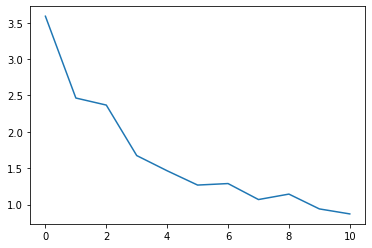

In [17]:
%matplotlib inline
plt.plot(losses)

In [26]:
xx = torch.rand(10000, 3)*8-4
with torch.no_grad():
    zz, logDetJ = model.flow(xx, True)

In [27]:
logDetJ.max(), logDetJ.min()

(tensor(4.1791), tensor(-0.0820))

In [38]:
torch.randn(10).log()

tensor([-0.2714, -0.4052,     nan, -0.7845,  0.3615,     nan,     nan,  0.1006,
            nan, -0.0988])